# Named Entity Recognition

# Bio-Entity Recognition Task at BioNLP/NLPBA 2004:
### Task Definition:
The task aims to identify and classify technical terms in the domain of molecular biology that correspond to instances of concepts that are of interest to biologists.
### Data:
The training data used in the task came from the GENIA version 3.02 corpus, This was formed from a controlled search on MEDLINE using the MeSH terms 'human', 'blood cells' and 'transcription factors'. From this search, 2,000 abstracts were selected and hand annotated according to a small taxonomy of 48 classes based on a chemical classification. Among the classes, 36 terminal classes were used to annotate the GENIA corpus. For the shared task we decided however to simplify the 36 classes and used only the classes protein, DNA, RNA, cell line and cell type.

### File Visualization:


In [2]:
import pandas as pd
from IPython.display import display_html

#Try to change this variable value
sentence_to_visualize = 0

with open("./BetterDataset/data.train", 'rb') as file_handle:
    file_content = file_handle.read().decode('utf-8').strip()
    annotated_sentences = file_content.split('\r\n\r\n')
    sentence = annotated_sentences[sentence_to_visualize]
    sentence = sentence.split()
    sentence = [sentence[i:i + 2] for i in range(0, len(sentence), 2)]
    cols=['Tokens','Entity']
    df2 = pd.DataFrame(sentence, columns=cols)
    df2_styler = df2.reset_index(drop=True).style.set_table_attributes("style='display:inline'").set_caption('Entities Distribution')
    display_html(df2_styler._repr_html_(), raw=True)

,Tokens,Entity
0,IL-2,B-DNA
1,gene,I-DNA
2,expression,O
3,and,O
4,NF-kappa,B-protein
5,B,I-protein
6,activation,O
7,through,O
8,CD28,B-protein
9,requires,O


# Task:1 Prepare the dataset for the model
### Read data from a ConLL file:

In [1]:
import os
def read_conll(filename_end):
    word_pos = 0
    pos_pos= None
    iob_pos = 3
    sep = '\t'
    IOB= 'IOB2'
    corpus_root="./BetterDataset"

    for root, dirs, files in os.walk(corpus_root):
        for filename in files:
            if filename.endswith(filename_end):
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    try:
                        file_content = file_handle.read().decode('utf-8').strip()
                    except:
                        raise ValueError("Can't process!")
                    
                    annotated_sentences = file_content.split('\r\n\r\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq for seq in annotated_sentence.split('\r\n')]
                        all_tokens = []
                        #print(annotated_tokens)
                        for annotation in annotated_tokens:
                            conll_tokens = annotation.split(sep)
                            #print(conll_tokens)
                            all_tokens.append(conll_tokens)
                        yield all_tokens
                            
                            
data_train = list(read_conll('.train'))
data_test = list(read_conll('.test'))

#We can visualize the input for each sentence:
print(data_train[0])

[['IL-2', 'B-DNA'], ['gene', 'I-DNA'], ['expression', 'O'], ['and', 'O'], ['NF-kappa', 'B-protein'], ['B', 'I-protein'], ['activation', 'O'], ['through', 'O'], ['CD28', 'B-protein'], ['requires', 'O'], ['reactive', 'O'], ['oxygen', 'O'], ['production', 'O'], ['by', 'O'], ['5-lipoxygenase', 'B-protein'], ['.', 'O']]


### Dataset Statistics:

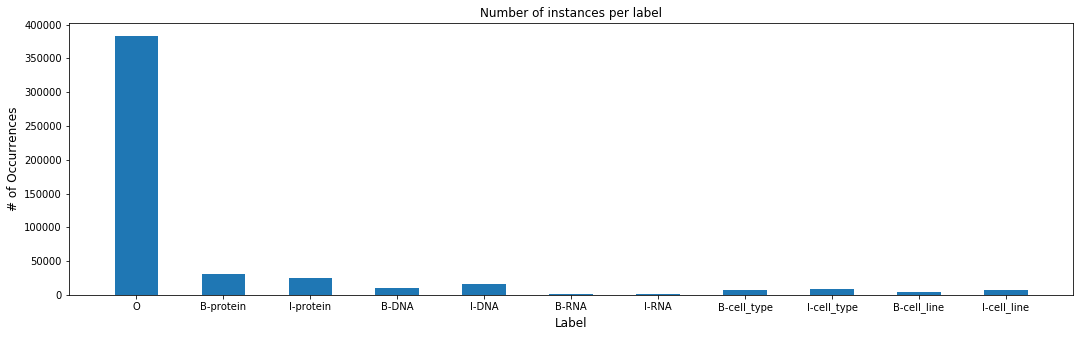

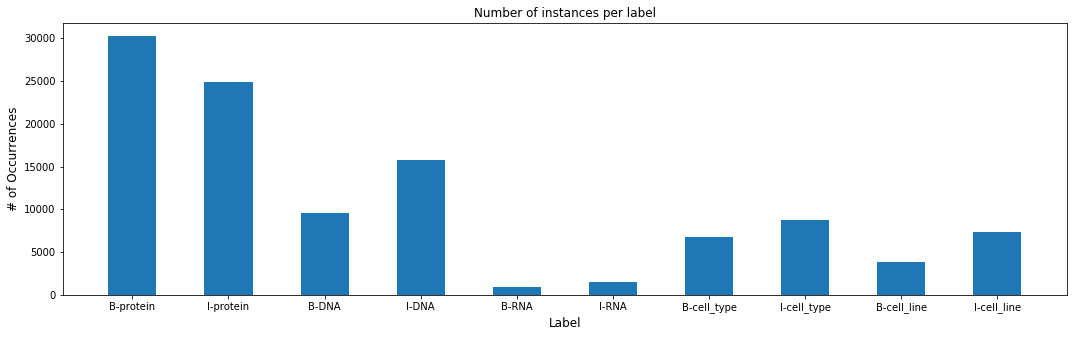

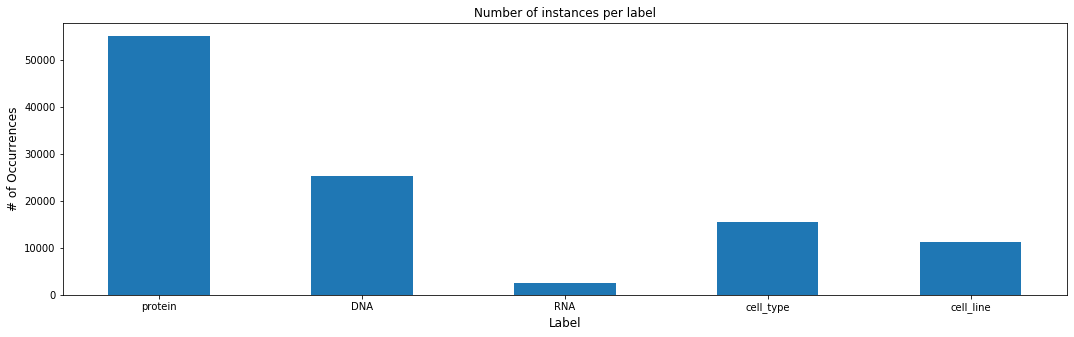

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def visualizeClassImbalance(data):
    # View the class count distribution
    array = np.array(data)
    
    dic={"O":0,"B-protein":0,"I-protein":0,"B-DNA":0, "I-DNA":0, "B-RNA":0, "I-RNA":0,
         "B-cell_type":0,"I-cell_type":0, "B-cell_line":0, "I-cell_line":0}
    for sub_array in array:
        for sub_sub_array in sub_array:
            dic[sub_sub_array[1]]=dic.get(sub_sub_array[1])+1
    f, ax = plt.subplots(figsize=(18,5)) 
    plt.bar(dic.keys(), dic.values(),width=0.5, color='C0')
    plt.title("Number of instances per label")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.show()
    
    dic={"B-protein":0,"I-protein":0,"B-DNA":0, "I-DNA":0, "B-RNA":0, "I-RNA":0,
         "B-cell_type":0,"I-cell_type":0, "B-cell_line":0, "I-cell_line":0}
    for sub_array in array:
        for sub_sub_array in sub_array:
            if sub_sub_array[1] in dic:
                dic[sub_sub_array[1]]=dic.get(sub_sub_array[1])+1
    f, ax = plt.subplots(figsize=(18,5)) 
    plt.bar(dic.keys(), dic.values(),width=0.5, color='C0')
    plt.title("Number of instances per label")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.show()
    
    dic={"protein":0,"DNA":0,"RNA":0,"cell_type":0,"cell_line":0}
    for sub_array in array:
        for sub_sub_array in sub_array:
            if sub_sub_array[1][2:] in dic:
                dic[sub_sub_array[1][2:]]=dic.get(sub_sub_array[1][2:])+1
    f, ax = plt.subplots(figsize=(18,5)) 
    plt.bar(dic.keys(), dic.values(),width=0.5, color='C0')
    plt.title("Number of instances per label")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.show()



data_train = list(read_conll('.train'))
data_test = list(read_conll('.test'))

visualizeClassImbalance(data_train)


### Merge sentence and label vectors:

In [4]:
def transform(data):
    sentences_array=[]
    labels_array=[]
    for data_input in data:
        sentence=[]
        labels=[]
        for vec in data_input:
            sentence.append(vec[0])
            labels.append(vec[1])
        sentences_array.append(sentence)
        labels_array.append(labels)

    return sentences_array,labels_array

sentences_train, labels_train = transform(data_train)
sentences_test, labels_test = transform(data_test)

#We can visualize the input for each sentence:
print(sentences_train[0])
print(labels_train[0])

['IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5-lipoxygenase', '.']
['B-DNA', 'I-DNA', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O']


### Convert Labels to Numeric Values:

In [5]:
import numpy as np
def convert(labels_array):
    labels_array_changed = np.copy(labels_array)
    for idx,label_vec in enumerate(labels_array_changed):
        for idx,label in enumerate(label_vec):
            if label=="O":
                label_vec[idx]=0
            if label=="B-protein":
                label_vec[idx]=1
            if label=="I-protein":
                label_vec[idx]=2
            if label=="B-DNA":
                label_vec[idx]=3
            if label=="I-DNA":
                label_vec[idx]=4
            if label=="B-RNA":
                label_vec[idx]=5
            if label=="I-RNA":
                label_vec[idx]=6
            if label=="B-cell_type":
                label_vec[idx]=7
            if label=="I-cell_type":
                label_vec[idx]=8
            if label=="B-cell_line":
                label_vec[idx]=9
            if label=="I-cell_line":
                label_vec[idx]=10
    return labels_array_changed

labels_train_transformed = convert(labels_train)
labels_test_transformed = convert(labels_test)
print(labels_train_transformed.shape)
print(labels_test_transformed.shape)
print(labels_train_transformed[0])
print(labels_test_transformed[0])

(18546,)
(105,)
[3, 4, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 7, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]


### Optional to convert to one-hot encoding :

In [6]:
import keras
def to_categorical(labels_array):
    print(labels_array.shape)
    labels_train_changed = np.copy(labels_array)
    for idx,label_vec in enumerate(labels_train_changed):
        label_vec = keras.utils.to_categorical(label_vec, num_classes=11, dtype='float32')
        labels_train_changed[idx]=label_vec
    return labels_train_changed

print(labels_train_transformed[0])
example = to_categorical(labels_train_transformed)
print(example[0])

Using TensorFlow backend.


[3, 4, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
(18546,)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Visualize Reports length:

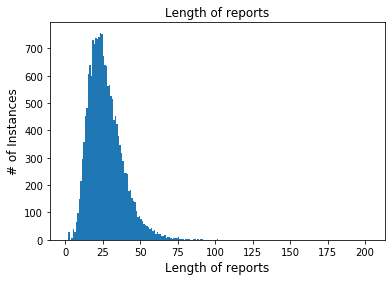

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
tlen = [len(x) for x in sentences_train] 
fig, ax = plt.subplots()
plt.hist(tlen, bins=np.arange(max(tlen)), histtype='barstacked', linewidth=2)
plt.title("Length of reports")
plt.ylabel('# of Instances', fontsize=12)
plt.xlabel('Length of reports', fontsize=12)
plt.show()

### Padding to Input Shape:

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)
tokenizer.fit_on_texts(sentences_test)
voc_size = len(tokenizer.word_index)+1

def convert2(x,y):
    X_total = tokenizer.texts_to_sequences(x)
    X_total = pad_sequences(X_total, maxlen=50, padding='post')
    Y_total = pad_sequences(y, maxlen=50, padding='post', value=0)
    return X_total,Y_total

X_train, y_train = convert2(sentences_train, labels_train_transformed)
X_test, y_test = convert2(sentences_test, labels_test_transformed)

print("Input Shapes:")
print(X_train.shape)
print(X_test.shape)

print("Target Shapes:")
y_train = np.expand_dims(y_train, axis=2)
print(y_train.shape)
y_test = np.expand_dims(y_test, axis=2)
print(y_test.shape)

Input Shapes:
(18546, 50)
(105, 50)
Target Shapes:
(18546, 50, 1)
(105, 50, 1)


### Metric Evaluation:

In [9]:
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
def new_sparse_categorical_accuracy(y_true, y_pred):
        y_pred_rank = ops.convert_to_tensor(y_pred).get_shape().ndims
        y_true_rank = ops.convert_to_tensor(y_true).get_shape().ndims
        # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
        if (y_true_rank is not None) and (y_pred_rank is not None) and (len(K.int_shape(y_true)) == len(K.int_shape(y_pred))):
            y_true = array_ops.squeeze(y_true, [-1])
        y_pred = math_ops.argmax(y_pred, axis=-1)
        # If the predicted output and actual output types don't match, force cast them
        # to match.
        if K.dtype(y_pred) != K.dtype(y_true):
            y_pred = math_ops.cast(y_pred, K.dtype(y_true))
        return math_ops.cast(math_ops.equal(y_true, y_pred), K.floatx())

# Attempt 1:
### Create Model:

In [10]:
from keras.models import Model
from keras.layers import Dense,TimeDistributed, Input, Embedding,Bidirectional,LSTM,Dropout
from sklearn.utils import class_weight
import numpy as np

def create_model(voc):
    sequence_input = Input(shape=(50,), dtype='int32')
    embedded_sequences = Embedding(voc, 32, input_length=50)(sequence_input)
    bilstm = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=False))(embedded_sequences)
    dense = Dense(256)(bilstm)
    drop = Dropout(0.2)(dense)
    preds = TimeDistributed(Dense(11, activation='softmax'))(drop)
    model = Model(inputs=sequence_input, outputs=preds)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[new_sparse_categorical_accuracy])
    model.summary()
    return model

model = create_model(voc_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 32)            643520    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           164864    
_________________________________________________________________
dense_1 (Dense)              (None, 50, 256)           65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 11)            2827      
Total params: 877,003
Trainable params: 877,003
Non-trainable params: 0
_________________________________________________________________


### Train:

In [11]:
from keras_tqdm import TQDMNotebookCallback
from sklearn_crfsuite import metrics

model.fit(x=X_train, y=y_train,validation_split=0.2,batch_size=32, epochs=3,verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True)])
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = np.expand_dims(y_pred, axis=2)
print(metrics.flat_classification_report(y_test, y_pred, digits=3))




              precision    recall  f1-score   support

           0      0.972     0.980     0.976      4770
           1      0.529     0.726     0.612       124
           2      0.734     0.457     0.563       151
           3      0.308     0.667     0.421         6
           4      0.360     1.000     0.529         9
           5      0.000     0.000     0.000        15
           6      0.857     0.231     0.364        26
           7      0.711     0.582     0.640        55
           8      0.836     0.593     0.694        86
           9      0.400     1.000     0.571         2
          10      0.353     1.000     0.522         6

    accuracy                          0.942      5250
   macro avg      0.551     0.658     0.536      5250
weighted avg      0.944     0.942     0.940      5250



### Train2:

In [12]:
from sklearn_crfsuite import metrics
from sklearn.utils import class_weight
import numpy as np

def checkifAllOut(sentence):
    for output in sentence:
        if(output!=0):
            return True
    return False

def RemoveOnlyOtherSentences(x_train,y_train):
    x_train_final = []
    y_train_final = []
    for idx, sentence in enumerate(y_train):
        if(checkifAllOut(sentence)):
            x_train_final.append(x_train[idx])
            y_train_final.append(sentence)
    return np.array(x_train_final),np.array(y_train_final)

unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

X_train_new, y_train_new = RemoveOnlyOtherSentences(X_train,y_train)

unique, counts = np.unique(y_train_new, return_counts=True)
print(unique)
print(counts)

print(X_train_new.shape)
print(y_train_new.shape)

model.fit(x=X_train_new, y=y_train_new,validation_split=0.2,batch_size=64,
          epochs=3,verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True)])
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = np.expand_dims(y_pred, axis=2)
print(metrics.flat_classification_report(y_test, y_pred, digits=3))


[ 0  1  2  3  4  5  6  7  8  9 10]
[819129  29916  24538   9399  15547    926   1493   6630   8645   3775
   7302]
[ 0  1  2  3  4  5  6  7  8  9 10]
[724279  29916  24538   9399  15547    926   1493   6630   8645   3775
   7302]
(16649, 50)
(16649, 50, 1)



              precision    recall  f1-score   support

           0      0.970     0.983     0.976      4770
           1      0.592     0.702     0.642       124
           2      0.793     0.430     0.558       151
           3      0.300     0.500     0.375         6
           4      0.333     1.000     0.500         9
           5      0.000     0.000     0.000        15
           6      0.714     0.192     0.303        26
           7      0.681     0.582     0.627        55
           8      0.769     0.581     0.662        86
           9      0.333     1.000     0.500         2
          10      0.300     1.000     0.462         6

    accuracy                          0.942      5250
   macro avg      0.526     0.634     0.510      5250
weighted avg      0.942     0.942     0.939      5250



In [13]:
from keras.models import Model
from keras.layers import Dense,TimeDistributed, Input, Embedding,Bidirectional,LSTM,Dropout
from keras_contrib.layers import CRF
from keras_contrib import losses, metrics
from sklearn.utils import class_weight
import numpy as np


def create_model(voc):
    sequence_input = Input(shape=(50,), dtype='int32')
    embedded_sequences = Embedding(voc,64, input_length=50)(sequence_input)
    bilstm = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=False))(embedded_sequences)
    dense = Dense(256)(bilstm)
    drop = Dropout(0.2)(dense)
    preds = TimeDistributed(Dense(64, activation='relu'))(drop)
    crf = CRF(11)
    out = crf(preds)
    model = Model(inputs=sequence_input, outputs=out)
    model.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[metrics.crf_accuracy])
    model.summary()
    return model



model = create_model(voc_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 64)            1287040   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           197632    
_________________________________________________________________
dense_3 (Dense)              (None, 50, 256)           65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 64)            16448     
_________________________________________________________________
crf_1 (CRF)                  (None, 50, 11)            858       
Total para

In [14]:
y_train_input = np.squeeze(y_train_new, axis=2)
from keras.utils import to_categorical
from sklearn_crfsuite import metrics
# One-Hot encode
y = [to_categorical(i, num_classes=11) for i in y_train_new]  # n_tags+1(PAD)
y = np.array(y)
print(y.shape)

model.fit(x=X_train_new, y=y,validation_split=0.2,batch_size=64,
          epochs=3,verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True)])
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = np.expand_dims(y_pred, axis=2)
print(metrics.flat_classification_report(y_test, y_pred, digits=3))

(16649, 50, 11)



              precision    recall  f1-score   support

           0      0.979     0.977     0.978      4770
           1      0.535     0.806     0.643       124
           2      0.794     0.536     0.640       151
           3      0.200     0.500     0.286         6
           4      0.250     1.000     0.400         9
           5      0.000     0.000     0.000        15
           6      0.778     0.269     0.400        26
           7      0.674     0.564     0.614        55
           8      0.771     0.628     0.692        86
           9      0.400     1.000     0.571         2
          10      0.500     1.000     0.667         6

    accuracy                          0.943      5250
   macro avg      0.535     0.662     0.536      5250
weighted avg      0.950     0.943     0.944      5250

